# Install dependencies (run only once)

In [ ]:
import os
if os.getcwd() != '/content/tprl-lsml-2022':

  !apt-get install swig cmake libopenmpi-dev zlib1g-dev xvfb x11-utils ffmpeg -qq 

  !git clone https://github.com/telejesus2/tprl-lsml-2022.git
  %load tprl-lsml-2022/agents/common_all.py
  import sys
  sys.path.insert(0,'/content/tprl-lsml-2022')
  !pip install swig
  !pip install pybullet
  !pip install gym==0.18.0
  !pip install box2d-py

  from natsort import natsorted
  from pathlib import Path
  import base64
  from IPython import display as ipythondisplay

  # Set up fake display; otherwise rendering will fail
  import os
  os.system("Xvfb :1 -screen 0 1024x768x24 &")
  os.environ['DISPLAY'] = ':1'

  # Display video
  def show_videos(video_path='', prefix=''):
    html = []
    for mp4 in natsorted(Path(video_path).glob("{}*.mp4".format(prefix))):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                  </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

  import numpy as np
  import time
  import math
  import random
  import torch
  import torch.nn.functional as F
  from torch.utils.tensorboard import SummaryWriter
  %load_ext tensorboard

  from utils.utils import PiecewiseSchedule
  from environments.gym import GymEnv
  from networks.policy import Policy
  from networks.value_fun import ValueFunction
  from networks.q_fun import QFunction
  from agents.common_on_policy import OnPolicyAgent
  from agents.common_off_policy import OffPolicyAgent
  from utils.plot import plot
  import utils.logz as logz

  # define device
  # device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  device = torch.device("cpu")
  print(device)

Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 128216 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.5-0ubuntu1_amd64.deb ...
Unpacking libxxf86dga1:amd64 (2:1.1.5-0ubuntu1) ...
Selecting previously unselected package swig4.0.
Preparing to unpack .../swig4.0_4.0.1-5build1_amd64.deb ...
Unpacking swig4.0 (4.0.1-5build1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.1-5build1_all.deb ...
Unpacking swig (4.0.1-5build1) ...
Selecting previously unselected package x11-utils.
Preparing to unpack .../x11-utils_7.7+5_amd64.deb ...
Unpacking x11-utils (7.7+5) ...
Selecting previously unselected package xvfb.
Preparing to unpack .../xvfb_2%3a1.20.13-1ubuntu1~20.04.6_amd64.deb ...
Unpacking xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up xvfb (2:1.20.13-1ubuntu1~20.04.6) ...
Setting up libxxf86dga1:amd64 (2:1.1.5-0ubuntu1) ...
Setting up x11-utils (7.7+5) ...
Setting up swig4.0 (4.0.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 KB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.8-cp38-cp38-linux_x86_64.whl size=2835093 sha256=6172a1c13333fbd398c6fbea1734b85f43dd861686456e7f35391499c367f137
  Stored in directory: /root/.cache/pip/wheels/cc/4f/d6/44eb0a9e6fea384e58f19cb0c4125e46a23af2b33fe3a7e81c
Successfully built box2d-py
cpu


In [56]:
cd tprl-lsml-2022/

[Errno 2] No such file or directory: 'tprl-lsml-2022/'
/content/tprl-lsml-2022


# 1 Introduction

*   Do not forget to enable the GPU.
*   We recommend SAVING THE RESULTS of your experiments as you go (see cell below).
*   Each training might take a LONG TIME if you are unlucky (up to 25 minutes). We recommend to open a separate copy of the notebook to debug your code for the final questions while you run experiments here.
*   Try not to stop a cell that is currently training, as it might mess up the rendering of the agent in future runs. If you encounter such a problem, you might have to reset the notebook. Before doing so, do not forget to save the results of your experiments.


YOUR CODE STARTS HERE appears wherever you are expected to write your own code (questions 3.2 and 4.1). For the experiments, there are some recommended hyper-parameters as comments in the code, but they might not be optimal so feel free to change them. We ask you to plot your results with the plot function:

In [57]:
# Plot the average return for one experiment 
# plot(['cartpole_DQN_0'], value='MeanReturn')
#  
# Plot the average return for two experiments. If both experiments have the same name, they will be averaged together.
#plot(['cartpole_PG_0', 'cartpole_PG_1'], value='MeanReturn')

# Plot the number of episodes for two experiments, and manually override their name.
#plot(['cartpole_PG_0', 'cartpole_PG_1'], legend=['exp1', 'exp2'], value='Episodes')

# Plot the average return as a function of the number of episodes
# plot(['pendulum_PG_0', 'pendulum_DDPG_0'], legend=['pg', 'ddpg'], value='MeanReturn', x='Episodes')

In [91]:
# SAVING THE RESULTS
!zip -r /content/file.zip /content/tprl-lsml-2022/experiments
from google.colab import files
files.download("/content/file.zip")

updating: content/tprl-lsml-2022/experiments/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/log.txt (deflated 49%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/video_100.mp4 (deflated 15%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/params.json (deflated 37%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/log.txt (deflated 72%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/params.json (deflated 39%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/video_140000.mp4 (deflated 12%)
updating: content/tprl-lsml-2022/experiments/baseline_pendulum_PG/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_pendulum_PG/log.txt (deflated 57%)
updating: content/tprl-lsml-2022/experiment

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Utilities (run only once)

Agent initializers:

In [59]:
def pg_agent(env, net_params, alg_params):
  ob_dim = env.observation_dim
  ac_dim = env.action_dim
  if env.is_discrete:
      policy = Policy(ob_dim, ac_dim, 'softmax', lr=net_params['policy_lr'], hidden=net_params['policy_hidden'])
  else:
      policy = Policy(ob_dim, ac_dim, 'gaussian', env.max_action, env.min_action, lr=net_params['policy_lr'], hidden=net_params['policy_hidden'])
  if net_params['nn_baseline']:
      value_fun = ValueFunction(ob_dim, lr=net_params['value_lr'], hidden=net_params['value_hidden'])
  else:
      value_fun = None

  return PG(env, device, policy, value_fun, **alg_params)


def dqn_agent(env, net_params, alg_params, exploration):
  if not env.is_discrete:
      raise RuntimeError('DQN only works for discrete environments')
  if alg_params['alternative_car_reward'] and env._short_name != 'car':
      raise RuntimeError('You should not use the alternative car reward outside of the car environment')

  ob_dim = env.observation_dim
  ac_dim = env.action_dim
  q_fun = QFunction(ob_dim, ac_dim, discrete=True, lr=net_params['q_lr'], hidden=net_params['q_hidden'], target=True)

  return DQN(env, device, q_fun, exploration=exploration, **alg_params)


def ddpg_agent(env, net_params, alg_params, exploration):
  if env.is_discrete:
      raise RuntimeError('DDPG only works for continuous environments')

  ob_dim = env.observation_dim
  ac_dim = env.action_dim
  policy = Policy(ob_dim, ac_dim, 'deterministic', env.max_action, env.min_action,
      lr=net_params['policy_lr'], hidden=net_params['policy_hidden'], target=True)
  q_fun = QFunction(ob_dim, ac_dim, discrete=False,
      lr=net_params['q_lr'], hidden=net_params['q_hidden'], target=True)

  return DDPG(env, device, policy, q_fun, exploration_noise=exploration, **alg_params)

Training loop:

In [60]:
def train(agent, max_frames, max_iterations, EVAL_INTERVAL, LOG_INTERVAL, logdir, writer=None):
  num_eval_episodes = 2
  itr = 1
  while agent._frame <= max_frames and itr <= max_iterations:

      # collect rollouts
      agent.collect_rollouts(itr)
          
      # update agent
      agent.update()

      # log diagnostics
      if itr % LOG_INTERVAL == 0:
          print("********** Iteration %i ************"%itr)
          logz.log_tabular("Iteration", itr)
          stats = agent.log_progress()
          for x in stats.keys():
              if writer is not None:
                  writer.add_scalar(x, stats[x], itr)
              logz.log_tabular(x, stats[x])
          logz.dump_tabular()

      # eval agent
      if itr % EVAL_INTERVAL == 0:
          agent.eval_env.setup_recording(os.path.join(logdir, 'eval', 'video_' + str(itr)))
          episode_returns, episode_lengths = agent.eval(num_eval_episodes, render=True)
          print("---------------------------------------")
          print("Evaluation over %d episodes: %f" % (num_eval_episodes, np.mean(episode_returns)))
          print("---------------------------------------")
          if writer is not None:
              writer.add_scalar('EvalMeanReturn', np.mean(episode_returns), itr)
          time.sleep(1)
          show_videos(os.path.join(logdir, 'eval'), 'video_' + str(itr))

      itr += 1

Miscellaneous:

In [61]:
def normalize(values, mean=0., std=1.):
    values = (values - values.mean()) / (values.std() + 1e-8)
    return mean + (std + 1e-8) * values

def make_next_dir(dir_):
    dir = dir_ + str(0)
    i = 1
    while os.path.exists(dir):
        dir = dir_ + str(i)
        i += 1 
    os.mkdir(dir)
    os.mkdir(os.path.join(dir, 'eval'))
    return dir

def setup_dir(dir, params):
    logdir = make_next_dir(dir)
    logz.configure_output_dir(logdir)
    logz.save_params(params)
    return logdir

# 2 Policy gradient

### Assignment

**Question 2.1**

Plot a graph that compares the performance of two different experiments in the cartpole environment, that differ on one (or more) parameters. Are the results expected? You should be able to reach a maximum score of 200 pretty easily.

How is exploration handled in policy gradient?

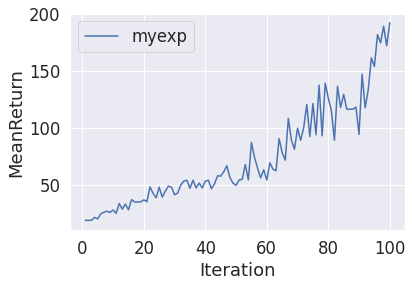

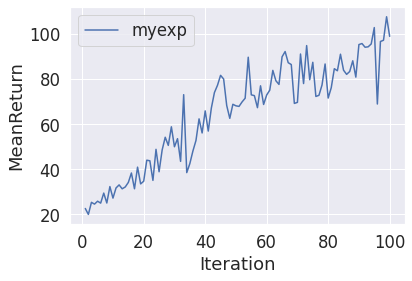

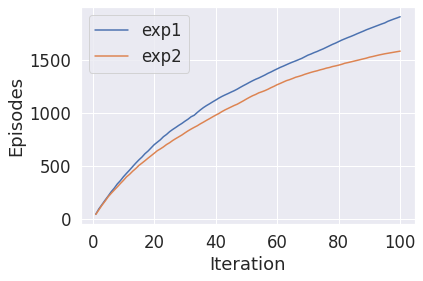

In [62]:
# Plot the average return for one experiment 
# plot(['cartpole_DQN_0'], value='MeanReturn')
#  
# Plot the average return for two experiments. If both experiments have the same name, they will be averaged together.
plot(['cartpole_PG_2'], value='MeanReturn') #reward-to-go = True
plot(['cartpole_PG_0'], value='MeanReturn')

# Plot the number of episodes for two experiments, and manually override their name.
plot(['cartpole_PG_0', 'cartpole_PG_2'], legend=['exp1', 'exp2'], value='Episodes')

# Plot the average return as a function of the number of episodes
# plot(['pendulum_PG_0', 'pendulum_DDPG_0'], legend=['pg', 'ddpg'], value='MeanReturn', x='Episodes')

It does not seem that we are not reaching the score of 200 easily when reward-to-go is set to True. We are mainly around 150. In our first experiment though (PG_0), we reached it. Hence, it is what we could have expected. When we try to reduce variance, we are not reaching 200 anymore. Policy exploration is handled by adding a noise in the definition of normalize (1e-8).


**Question 2.2**

Plot a graph that compares the performance of two different experiments in the lunar-continuous environment, one with and one without the baseline. Are the results expected? If you choose the recommended parameters, you should reach rewards of around 100, and one experiment should take around 20 minutes. Do not run the experiment without the baseline yourself, use the results from the folder baseline_lunar-continuous_PG instead.

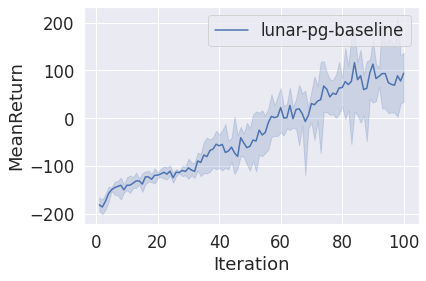

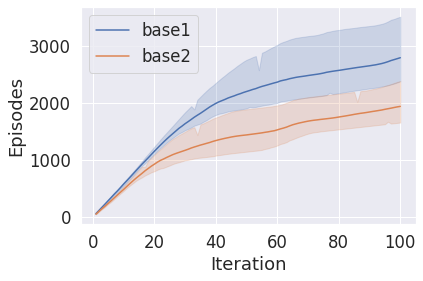

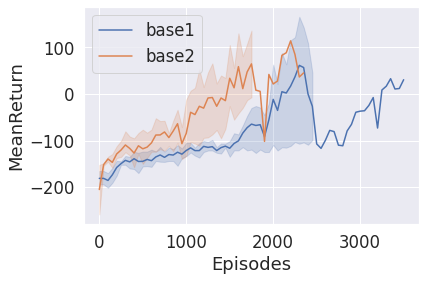

In [73]:
# PLOT GRAPH
# Plot the average return for one experiment 
# plot(['cartpole_DQN_0'], value='MeanReturn')
#  
# Plot the average return for two experiments. If both experiments have the same name, they will be averaged together.
plot(['baseline_lunar_PG'], value='MeanReturn')

# Plot the number of episodes for two experiments, and manually override their name.
plot(['baseline_lunar_PG', 'baseline_lunar-continuous_PG'], legend=['base1', 'base2'], value='Episodes')

# Plot the average return as a function of the number of episodes
plot(['baseline_lunar_PG', 'baseline_lunar-continuous_PG'], legend=['base1', 'base2'], value='MeanReturn', x='Episodes')


The baseline seems effectivly to reach 100 but the first lunar baseline is quicker.

Then, I tried to do it without the baseline (see parameters below).


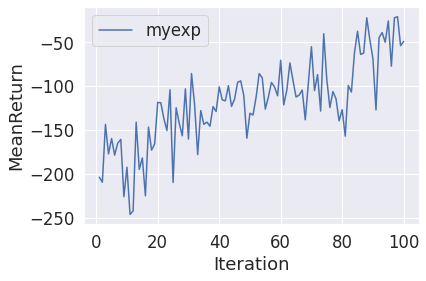

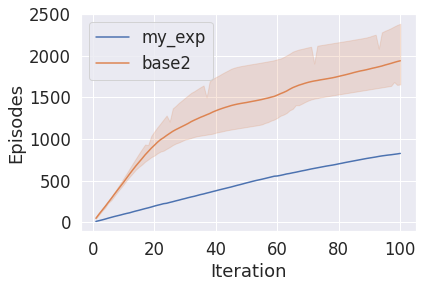

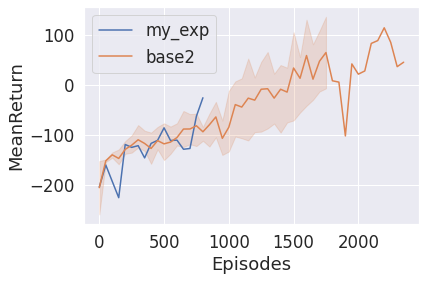

In [78]:
# PLOT GRAPH
# Plot the average return for one experiment 
# plot(['cartpole_DQN_0'], value='MeanReturn')
#  
# Plot the average return for two experiments. If both experiments have the same name, they will be averaged together.
plot(['lunar_PG_1'], value='MeanReturn')

# Plot the number of episodes for two experiments, and manually override their name.
plot(['lunar_PG_1', 'baseline_lunar-continuous_PG'], legend=['my_exp', 'base2'], value='Episodes')

# Plot the average return as a function of the number of episodes
plot(['lunar_PG_1', 'baseline_lunar-continuous_PG'], legend=['my_exp', 'base2'], value='MeanReturn', x='Episodes')


*Your answer*

### REINFORCE implementation

In [ ]:
class PG(OnPolicyAgent):
    def __init__(self, env, device, policy, value_fun=None, batch_size=64, discount_factor=0.99, normalize_advantages=True, reward_to_go=True, max_path_frames=50
        ):
        super(PG, self).__init__(env, device, batch_size, max_path_frames)
        self.gamma = discount_factor
        self.normalize_advantages = normalize_advantages
        self.reward_to_go = reward_to_go

        # policy network
        self.policy = policy
        self.policy.to_(self.device)

        # value function network
        self.value_fun = value_fun
        self.nn_baseline = False
        if value_fun is not None:
            self.nn_baseline = True
            self.value_fun.to_(self.device)

    @torch.no_grad()
    def act(self, ob, eval=False):
        ob = self.env.process_state(ob)
        if eval:
            ac = self.policy.forward(ob, eval=True)
        else:
            pi = self.policy.net(ob)
            ac = pi.sample()
        return self.env.process_action(ac)

    def update(self):
        """
        :var states: tensor of observations of shape (N, ob_dim)
        :var actions: tensor of actions of shape (N, ac_dim) or shape (N) if discrete
        :var advs: tensor of advantages of shape (N)
        """
        states = self.buffer.observations()
        actions = self.buffer.actions()

        if self.nn_baseline:
            returns = self.buffer.returns_to_go(self.gamma, add_last_values=True, update_last_values_with=self.value_fun.net) # shape (N)
            values = self.value_fun.net(states).view(-1)    # shape (N)

            # update baseline
            targets = normalize(returns)
            value_loss = F.mse_loss(values, targets, reduction='mean')
            self.value_fun.optimize(value_loss)

            # compute advantages
            values = normalize(values.detach(), returns.mean(), returns.std())
            advs = returns - values
        else:
            if self.reward_to_go:
                advs = self.buffer.returns_to_go(self.gamma) # shape (N)
            else:
                advs = self.buffer.returns(self.gamma) # shape (N)

        # normalize advantages
        if self.normalize_advantages:
            advs = normalize(advs)

        # update policy
        pi = self.policy.net(states)
        logprobs = pi.log_prob(actions)
        policy_loss = - (logprobs * advs).mean()
        self.policy.optimize(policy_loss)

### Training (run experiments for questions 2.1 and 2.2)

Select an environment and a set of hyper-parameters. Don't forget to set a unique name for each experiment you do.

In [ ]:
# name your experiment
exp_name = 'myexp'

# choose the environment
env_names = ['cartpole', 'pendulum', 'lunar', 'lunar-continuous', 'car', 'car-continuous']
env_name = env_names[0]

# define the training parameters
max_training_frames = np.inf        
max_training_iterations = 100       # use 100 for cartpole, lunar-continuous       

# define the network parameters for the policy (and value function if 'nn_baseline' is True)
net_params = {
    'nn_baseline': False,            # question 2.2
    'value_lr': 0.005,
    'policy_lr': 0.005,
    'value_hidden': [64],       
    'policy_hidden': [32],          # use [32] for cartpole, [64, 64] for lunar-continuous
}

# define the algorithm parameters
alg_params = {
    'batch_size': 1000,             # use between 1000 and 5000 for cartpole, 5000 for lunar-continuous
    'discount_factor': 0.99,        
    'normalize_advantages': False,     # True should help reduce the variance
    'reward_to_go': False,             # True should help reduce the variance
    'max_path_frames': 10000,
}

# set up the logging directory (you don't have to change this)
logdir = setup_dir('experiments/' + env_name + '_PG_', {**net_params, **alg_params, **{'exp_name': exp_name}})
tbdir = os.path.join(logdir, 'runs')
cur_run = 0

Logging data to experiments/cartpole_PG_0/log.txt


We can change one of the two interesting hyperparameters (reward-to-go and batch size). Let's set reward-to-go to True.

In [ ]:
# name your experiment
exp_name = 'myexp'

# choose the environment
env_names = ['cartpole', 'pendulum', 'lunar', 'lunar-continuous', 'car', 'car-continuous']
env_name = env_names[0]

# define the training parameters
max_training_frames = np.inf        
max_training_iterations = 100       # use 100 for cartpole, lunar-continuous       

# define the network parameters for the policy (and value function if 'nn_baseline' is True)
net_params = {
    'nn_baseline': False,            # question 2.2
    'value_lr': 0.005,
    'policy_lr': 0.005,
    'value_hidden': [64],       
    'policy_hidden': [32],          # use [32] for cartpole, [64, 64] for lunar-continuous
}

# define the algorithm parameters
alg_params = {
    'batch_size': 800,             # use between 1000 and 5000 for cartpole, 5000 for lunar-continuous
    'discount_factor': 0.99,        
    'normalize_advantages': False,     # True should help reduce the variance
    'reward_to_go': True,             # True should help reduce the variance
    'max_path_frames': 10000,
}

# set up the logging directory (you don't have to change this)
logdir = setup_dir('experiments/' + env_name + '_PG_', {**net_params, **alg_params, **{'exp_name': exp_name}})
tbdir = os.path.join(logdir, 'runs')
cur_run = 0

Logging data to experiments/cartpole_PG_2/log.txt


In [74]:
# name your experiment
exp_name = 'myexp'

# choose the environment
env_names = ['cartpole', 'pendulum', 'lunar', 'lunar-continuous', 'car', 'car-continuous']
env_name = env_names[2]

# define the training parameters
max_training_frames = np.inf        
max_training_iterations = 100       # use 100 for cartpole, lunar-continuous       

# define the network parameters for the policy (and value function if 'nn_baseline' is True)
net_params = {
    'nn_baseline': True,            # question 2.2
    'value_lr': 0.005,
    'policy_lr': 0.005,
    'value_hidden': [64],       
    'policy_hidden': [64, 64],          # use [32] for cartpole, [64, 64] for lunar-continuous
}

# define the algorithm parameters
alg_params = {
    'batch_size': 800,             # use between 1000 and 5000 for cartpole, 5000 for lunar-continuous
    'discount_factor': 0.99,        
    'normalize_advantages': False,     # True should help reduce the variance
    'reward_to_go': False,             # True should help reduce the variance
    'max_path_frames': 10000,
}

# set up the logging directory (you don't have to change this)
logdir = setup_dir('experiments/' + env_name + '_PG_', {**net_params, **alg_params, **{'exp_name': exp_name}})
tbdir = os.path.join(logdir, 'runs')
cur_run = 0

Logging data to experiments/lunar_PG_1/log.txt


If you want, run this cell to monitor the training in real time. MeanReturn and EvalMeanReturn are the most important stats to monitor.

In [ ]:
%tensorboard --logdir  $tbdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-03-08 13:45:11.389228: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-08 13:45:11.389345: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-08 13:45:11.389360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are inst

Launch a training session. You can run it more than once by setting num_runs > 1 or by running the cell several times. Different runs from the same experiment will be averaged together when plotting the results.

In [75]:
EVAL_INTERVAL = 20 
LOG_INTERVAL = 1
num_runs = 1

for _ in range(num_runs):
    env = GymEnv(env_name, device)
    agent = pg_agent(env, net_params, alg_params)
    writer = SummaryWriter(os.path.join(tbdir, str(cur_run)))
    cur_run += 1
    train(agent, max_training_frames, max_training_iterations, EVAL_INTERVAL, LOG_INTERVAL, logdir, writer)
    env.close()

********** Iteration 1 ************
----------------------------------------
|          Iteration |               1 |
|               Time |         0.00937 |
|          Timesteps |             889 |
| TimestepsThisBatch |             889 |
|                fps |        1.58e+03 |
|         MeanReturn |            -204 |
|          StdReturn |             126 |
|          MaxReturn |           -30.7 |
|          MinReturn |            -395 |
|          EpLenMean |            98.8 |
|           EpLenStd |            28.2 |
|           Episodes |               9 |
----------------------------------------
********** Iteration 2 ************
----------------------------------------
|          Iteration |               2 |
|               Time |          0.0169 |
|          Timesteps |        1.75e+03 |
| TimestepsThisBatch |             865 |
|                fps |        1.92e+03 |
|         MeanReturn |            -210 |
|          StdReturn |             105 |
|          MaxReturn |    

********** Iteration 21 ************
----------------------------------------
|          Iteration |              21 |
|               Time |           0.215 |
|          Timesteps |        1.78e+04 |
| TimestepsThisBatch |             826 |
|                fps |             193 |
|         MeanReturn |            -119 |
|          StdReturn |            80.5 |
|          MaxReturn |            21.8 |
|          MinReturn |            -325 |
|          EpLenMean |            82.6 |
|           EpLenStd |            15.5 |
|           Episodes |             203 |
----------------------------------------
********** Iteration 22 ************
----------------------------------------
|          Iteration |              22 |
|               Time |           0.224 |
|          Timesteps |        1.87e+04 |
| TimestepsThisBatch |             848 |
|                fps |        1.68e+03 |
|         MeanReturn |            -137 |
|          StdReturn |            25.6 |
|          MaxReturn |  

********** Iteration 41 ************
----------------------------------------
|          Iteration |              41 |
|               Time |           0.431 |
|          Timesteps |        3.52e+04 |
| TimestepsThisBatch |             830 |
|                fps |             226 |
|         MeanReturn |            -116 |
|          StdReturn |            57.2 |
|          MaxReturn |           -55.6 |
|          MinReturn |            -270 |
|          EpLenMean |              83 |
|           EpLenStd |            26.5 |
|           Episodes |             387 |
----------------------------------------
********** Iteration 42 ************
----------------------------------------
|          Iteration |              42 |
|               Time |           0.439 |
|          Timesteps |         3.6e+04 |
| TimestepsThisBatch |             847 |
|                fps |        1.73e+03 |
|         MeanReturn |            -117 |
|          StdReturn |            55.6 |
|          MaxReturn |  

********** Iteration 61 ************
----------------------------------------
|          Iteration |              61 |
|               Time |           0.939 |
|          Timesteps |        5.26e+04 |
| TimestepsThisBatch |             808 |
|                fps |            37.8 |
|         MeanReturn |            -121 |
|          StdReturn |             105 |
|          MaxReturn |           -33.7 |
|          MinReturn |            -327 |
|          EpLenMean |             115 |
|           EpLenStd |              24 |
|           Episodes |             562 |
----------------------------------------
********** Iteration 62 ************
----------------------------------------
|          Iteration |              62 |
|               Time |           0.947 |
|          Timesteps |        5.34e+04 |
| TimestepsThisBatch |             820 |
|                fps |        1.89e+03 |
|         MeanReturn |            -104 |
|          StdReturn |            82.5 |
|          MaxReturn |  

********** Iteration 81 ************
----------------------------------------
|          Iteration |              81 |
|               Time |             1.2 |
|          Timesteps |        6.99e+04 |
| TimestepsThisBatch |             857 |
|                fps |             133 |
|         MeanReturn |            -157 |
|          StdReturn |            82.6 |
|          MaxReturn |             -67 |
|          MinReturn |            -318 |
|          EpLenMean |             122 |
|           EpLenStd |              28 |
|           Episodes |             708 |
----------------------------------------
********** Iteration 82 ************
----------------------------------------
|          Iteration |              82 |
|               Time |            1.21 |
|          Timesteps |        7.08e+04 |
| TimestepsThisBatch |             891 |
|                fps |        1.91e+03 |
|         MeanReturn |           -99.3 |
|          StdReturn |            54.2 |
|          MaxReturn |  

In [76]:
# SAVING THE RESULTS
!zip -r /content/file.zip /content/tprl-lsml-2022/experiments
from google.colab import files
files.download("/content/file.zip")

updating: content/tprl-lsml-2022/experiments/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/log.txt (deflated 49%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/video_100.mp4 (deflated 15%)
updating: content/tprl-lsml-2022/experiments/baseline_lunar-continuous_PG/params.json (deflated 37%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/log.txt (deflated 72%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/params.json (deflated 39%)
updating: content/tprl-lsml-2022/experiments/baseline_car_DQN/video_140000.mp4 (deflated 12%)
updating: content/tprl-lsml-2022/experiments/baseline_pendulum_PG/ (stored 0%)
updating: content/tprl-lsml-2022/experiments/baseline_pendulum_PG/log.txt (deflated 57%)
updating: content/tprl-lsml-2022/experiment

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 3 Q-learning

### Assignment

**Question 3.1**

Plot a graph that compares the performance of two different experiments in the car environment, one with the original reward and one with the alternative reward.  Are the results expected? If you choose the recommended parameters, you should reach decent original rewards when training from the alternative rewards, and one experiment should take around 10 minutes. Do not run the experiment with the original reward yourself, use the results from the folder baseline_car_DQN instead. Note that the logs always report the original rewards. 

Other than changing the reward function, which feels a bit like cheating, we could improve the exploration strategy. What do you think might help with the original problem (you don't have to implement it)?


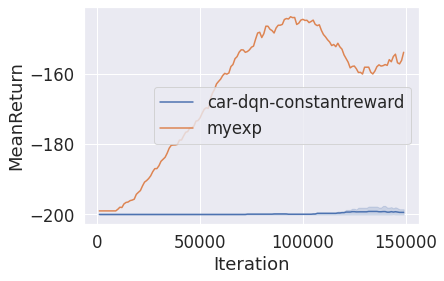

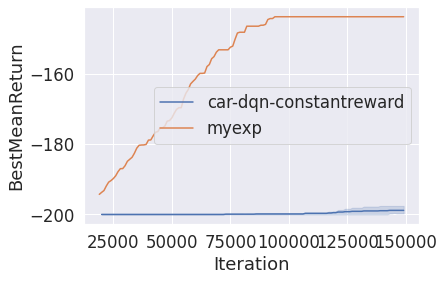

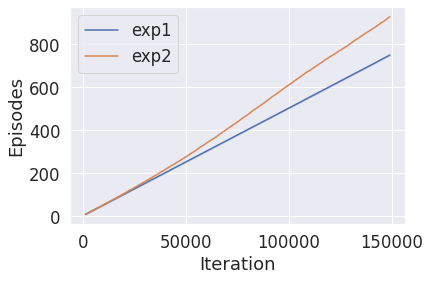

In [85]:
# PLOT GRAPH
# Plot the average return for one experiment 
# plot(['cartpole_DQN_0'], value='MeanReturn')
#  
# Plot the average return for two experiments. If both experiments have the same name, they will be averaged together.
plot(['baseline_car_DQN','car_DQN_0'], value='MeanReturn') #original reward
plot(['baseline_car_DQN','car_DQN_0'], value='BestMeanReturn') 

# Plot the number of episodes for two experiments, and manually override their name.
plot(['baseline_car_DQN', 'car_DQN_0'], legend=['exp1', 'exp2'], value='Episodes')

# Plot the average return as a function of the number of episodes
# plot(['pendulum_PG_0', 'pendulum_DDPG_0'], legend=['pg', 'ddpg'], value='MeanReturn', x='Episodes')


The reward function is not constant anymore indeed. The experiment lasted 10 minutes. According to these graphs and the videos during the training, the results were better and were expected. It is quite the impression of cheating indeed. 

To help the original situation we could use the idea of having a double DQN (to have two differents action-value simulator.

---



**Question 3.2**

First, you should complete the code in the 'DQN implementation' cell. Plot a graph that compares the performance of two different experiments in the lunar environment, one with and one without double DQN. Are the results expected? If you choose the recommended parameters, you should reach rewards of around 150, and one experiment should take around 20 minutes. Do not run the experiment without DDQN yourself, use the results from the folder baseline_lunar_DQN instead.

(Optional) In the previous section you have seen a policy gradient algorithm, which converges in theory (although usually to local optima). DQN doesn't have such guarantees. Can you imagine why? Aren't we doing gradient descent in both cases?


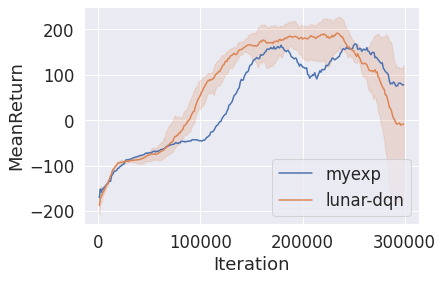

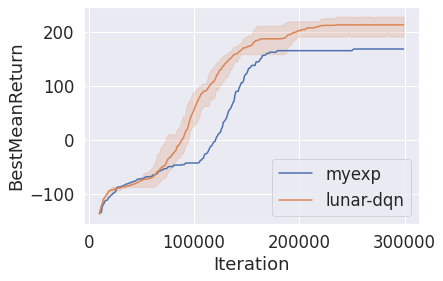

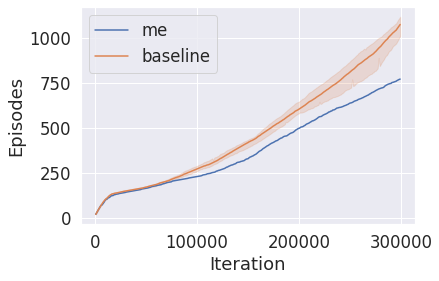

In [96]:
# PLOT GRAPH

# Plot the average return for two experiments. If both experiments have the same name, they will be averaged together.
plot(['lunar_DQN_0','baseline_lunar_DQN'], value='MeanReturn') #original reward
plot(['lunar_DQN_0','baseline_lunar_DQN'], value='BestMeanReturn') 

# Plot the number of episodes for two experiments, and manually override their name.
plot(['lunar_DQN_0', 'baseline_lunar_DQN'], legend=['me', 'baseline'], value='Episodes')

# Plot the average return as a function of the number of episodes
# plot(['pendulum_PG_0', 'pendulum_DDPG_0'], legend=['pg', 'ddpg'], value='MeanReturn', x='Episodes')


20 minutes indeed, we reached 150 with these two experiments. My experiment (with my parameters) even reached 200. SO this is the results we expected.

Plot a graph (with x='Episodes') that compares the performance of DQN against Reinforce in the discrete lunar environment. Which was more sample efficient? Why? Do not run the Reinforce experiment yourself, use the results from the folder lunar_PG_0 instead. 

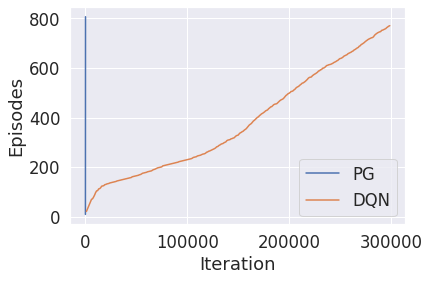

In [102]:
plot(['lunar_PG_0', 'lunar_DQN_0'], legend=['PG', 'DQN'], value='Episodes')

As seen this morning and as expected, DQN was more sample efficient than PG.

### DQN implementation (your code for question 3.2 goes here)

In [87]:
class DQN(OffPolicyAgent):
    def __init__(self, env, device, q_fun, batch_size=64, learning_starts=1000, learning_freq=4, replay_buffer_size=50000, max_path_frames=np.inf,
                 discount_factor=0.99, exploration=None, sync_every=3000, double_q=False, alternative_car_reward=False
        ):
        super(DQN, self).__init__(env, device, batch_size, learning_starts, learning_freq, replay_buffer_size, max_path_frames)
        self.double_q = double_q
        self.exploration = exploration
        self.gamma = discount_factor

        # q function network
        self.q_fun = q_fun
        self.q_fun.to_(self.device)
        self.q_fun.sync_target()

        # utilities for target updates (sync every x iterations)
        self._num_updates = 0
        self.sync_every = sync_every

        # alternative car reward
        self.alternative_car_reward = alternative_car_reward

    @torch.no_grad()
    def act(self, ob, eval=False):
        if not eval and (self._frame < self.learning_starts or random.random() < self.exploration.value(self._frame)):
            ac = self.env.action_space.sample()
        else:
            ac = self._exploit(ob, eval)
        return ac

    def _exploit(self, ob, eval):
        ob = self.env.process_state(ob)
        q = self.q_fun.forward(ob, eval=eval)
        ac = torch.argmax(q, axis=1)
        return self.env.process_action(ac)

    def update(self):
        self._update()
        self._num_updates += 1

        # periodically update the target network
        if self._num_updates % self.sync_every == 0:
            self.q_fun.sync_target()

    def _update(self):
        # sample transitions from buffer
        data = self.replay_buffer.sample(self.batch_size)
        states = data['states']					              # shape (N, ob_dim)
        next_states = data['next_states']		          # shape (N, ob_dim)
        actions = data['actions'].long().view(-1, 1)  # shape (N, 1)
        rewards = data['rewards']				              # shape (N, 1)
        done_mask = data['done_mask']  			          # shape (N, 1)

        # modify reward for the car environment
        if self.alternative_car_reward:
            for i, (state, next_state) in enumerate(zip(states, next_states)):
                rewards[i] = 100*((math.sin(3*next_state[0]) * 0.0025 + 0.5 * next_state[1] * next_state[1]) - (math.sin(3*state[0]) * 0.0025 + 0.5 * state[1] * state[1]))

        # compute q values
        q_values = self.q_fun.net(states).gather(1, actions)	# shape (N, 1)

        # compute targets
        with torch.no_grad():
            if not self.double_q:
                q_targets_next = self.q_fun.target_net(next_states).max(1, keepdim=True)[0]  # shape (N, 1)
            else:
                online_q_values = self.q_fun.net(next_states)
                target_q_values = self.q_fun.target_net(next_states)
                target_actions = torch.argmax(online_q_values, axis=1).unsqueeze(1)
                q_targets_next = target_q_values.gather(1, target_actions).detach()
            q_targets = rewards + (1 - done_mask) * self.gamma * q_targets_next

        # compute loss and update network
        loss = F.smooth_l1_loss(q_values, q_targets)
        self.q_fun.optimize(loss)

### Training (run experiments for questions 3.1 and 3.2)

Select an environment and a set of hyper-parameters. Don't forget to set a unique name for each experiment you do.

In [79]:
# name your experiment
exp_name = 'myexp'

# choose the environment
env_names = ['cartpole', 'lunar', 'car']
env_name = env_names[2]

# define the training parameters
max_training_frames = 150000        # use 150000 for car, 300000 for lunar
max_training_iterations = np.inf        

# define the network parameters for the q-function
net_params = {
    'q_lr': 0.005,
    'q_hidden': [64],     # use [64] for car, [64, 64] for lunar
}

# define the algorithm parameters
alg_params = {
    'batch_size': 32,         # use 32 for car, lunar 
    'learning_starts': 1000,  # use 1000 for car, lunar (update the model for the first time after collecting at least x frames)
    'learning_freq': 1,       # (collect x frames between each model update)
    'discount_factor': 0.95,  # use 0.95 for car, 1.00 for lunar
    'sync_every': 3000,       # use 3000 for car, lunar (sync the target network every x iterations)
    'double_q': False,        # question 3.2
    'max_path_frames': 10000,
    'replay_buffer_size': 50000,  # use 50000 for car, lunar
    'alternative_car_reward': True, # question 3.1
}

# exploration strategy (you don't have to change this)
time2 = max_training_frames * 0.1
exploration = PiecewiseSchedule(
    [(0, 1), (time2, 0.02)],   # waypoints: exploration threshold decreases linearly from value1 at time1 to value2 at time2, then stays at outside_value
    outside_value=0.02)

# set up the logging directory (you don't have to change this)
logdir = setup_dir('experiments/' + env_name + '_DQN_', {**net_params, **alg_params, **{'exp_name': exp_name}})
tbdir = os.path.join(logdir, 'runs')
cur_run = 0

Logging data to experiments/car_DQN_0/log.txt


In [89]:
# name your experiment
exp_name = 'myexp'

# choose the environment
env_names = ['cartpole', 'lunar', 'car']
env_name = env_names[1]

# define the training parameters
max_training_frames = 300000        # use 150000 for car, 300000 for lunar
max_training_iterations = np.inf        

# define the network parameters for the q-function
net_params = {
    'q_lr': 0.005,
    'q_hidden':  [64, 64],     # use [64] for car, [64, 64] for lunar
}

# define the algorithm parameters
alg_params = {
    'batch_size': 32,         # use 32 for car, lunar 
    'learning_starts': 1000,  # use 1000 for car, lunar (update the model for the first time after collecting at least x frames)
    'learning_freq': 1,       # (collect x frames between each model update)
    'discount_factor': 1,  # use 0.95 for car, 1.00 for lunar
    'sync_every': 3000,       # use 3000 for car, lunar (sync the target network every x iterations)
    'double_q': True,        # question 3.2
    'max_path_frames': 10000,
    'replay_buffer_size': 50000,  # use 50000 for car, lunar
    'alternative_car_reward': False, # question 3.1
}

# exploration strategy (you don't have to change this)
time2 = max_training_frames * 0.1
exploration = PiecewiseSchedule(
    [(0, 1), (time2, 0.02)],   # waypoints: exploration threshold decreases linearly from value1 at time1 to value2 at time2, then stays at outside_value
    outside_value=0.02)

# set up the logging directory (you don't have to change this)
logdir = setup_dir('experiments/' + env_name + '_DQN_', {**net_params, **alg_params, **{'exp_name': exp_name}})
tbdir = os.path.join(logdir, 'runs')
cur_run = 0

Logging data to experiments/lunar_DQN_0/log.txt


If you want, run this cell to monitor the training in real time. BestMeanReturn, MeanReturn and EvalMeanReturn are the most important stats to monitor.

In [80]:
%tensorboard --logdir  $tbdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-03-08 14:17:33.691291: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-08 14:17:33.691439: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-08 14:17:33.691458: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are inst

Launch a training session. You can run it more than once by setting num_runs > 1 or by running the cell several times. Different runs from the same experiment will be averaged together when plotting the results.

In [90]:
EVAL_INTERVAL = 20000
LOG_INTERVAL = 1000
num_runs = 1

for _ in range(num_runs):
    env = GymEnv(env_name, device)
    agent = dqn_agent(env, net_params, alg_params, exploration)
    writer = SummaryWriter(os.path.join(tbdir, str(cur_run)))
    cur_run += 1
    train(agent, max_training_frames, max_training_iterations, EVAL_INTERVAL, LOG_INTERVAL, logdir, writer)
    env.close()

********** Iteration 1000 ************
-------------------------------------
|       Iteration |           1e+03 |
|            Time |          0.0317 |
|       Timesteps |           2e+03 |
|      MeanReturn |            -171 |
|  BestMeanReturn |            -inf |
|        Episodes |              21 |
|     Exploration |           0.935 |
-------------------------------------
********** Iteration 2000 ************
-------------------------------------
|       Iteration |           2e+03 |
|            Time |          0.0609 |
|       Timesteps |           3e+03 |
|      MeanReturn |            -151 |
|  BestMeanReturn |            -inf |
|        Episodes |              31 |
|     Exploration |           0.902 |
-------------------------------------
********** Iteration 3000 ************
-------------------------------------
|       Iteration |           3e+03 |
|            Time |          0.0901 |
|       Timesteps |           4e+03 |
|      MeanReturn |            -158 |
|  BestMe

********** Iteration 21000 ************
-------------------------------------
|       Iteration |         2.1e+04 |
|            Time |            1.16 |
|       Timesteps |         2.2e+04 |
|      MeanReturn |            -102 |
|  BestMeanReturn |            -102 |
|        Episodes |             132 |
|     Exploration |           0.281 |
-------------------------------------
********** Iteration 22000 ************
-------------------------------------
|       Iteration |         2.2e+04 |
|            Time |             1.2 |
|       Timesteps |         2.3e+04 |
|      MeanReturn |            -101 |
|  BestMeanReturn |            -101 |
|        Episodes |             133 |
|     Exploration |           0.249 |
-------------------------------------
********** Iteration 23000 ************
-------------------------------------
|       Iteration |         2.3e+04 |
|            Time |            1.26 |
|       Timesteps |         2.4e+04 |
|      MeanReturn |           -99.2 |
|  Bes

********** Iteration 41000 ************
-------------------------------------
|       Iteration |         4.1e+04 |
|            Time |            2.78 |
|       Timesteps |         4.2e+04 |
|      MeanReturn |           -77.4 |
|  BestMeanReturn |           -77.4 |
|        Episodes |             154 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 42000 ************
-------------------------------------
|       Iteration |         4.2e+04 |
|            Time |            2.82 |
|       Timesteps |         4.3e+04 |
|      MeanReturn |             -78 |
|  BestMeanReturn |           -77.4 |
|        Episodes |             155 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 43000 ************
-------------------------------------
|       Iteration |         4.3e+04 |
|            Time |             2.9 |
|       Timesteps |         4.4e+04 |
|      MeanReturn |           -76.7 |
|  Bes

********** Iteration 61000 ************
-------------------------------------
|       Iteration |         6.1e+04 |
|            Time |            4.18 |
|       Timesteps |         6.2e+04 |
|      MeanReturn |           -64.8 |
|  BestMeanReturn |           -64.8 |
|        Episodes |             181 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 62000 ************
-------------------------------------
|       Iteration |         6.2e+04 |
|            Time |            4.25 |
|       Timesteps |         6.3e+04 |
|      MeanReturn |           -64.5 |
|  BestMeanReturn |           -64.5 |
|        Episodes |             182 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 63000 ************
-------------------------------------
|       Iteration |         6.3e+04 |
|            Time |             4.3 |
|       Timesteps |         6.4e+04 |
|      MeanReturn |           -64.2 |
|  Bes

********** Iteration 81000 ************
-------------------------------------
|       Iteration |         8.1e+04 |
|            Time |            5.43 |
|       Timesteps |         8.2e+04 |
|      MeanReturn |           -46.4 |
|  BestMeanReturn |           -46.4 |
|        Episodes |             210 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 82000 ************
-------------------------------------
|       Iteration |         8.2e+04 |
|            Time |            5.49 |
|       Timesteps |         8.3e+04 |
|      MeanReturn |           -46.7 |
|  BestMeanReturn |           -46.4 |
|        Episodes |             211 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 83000 ************
-------------------------------------
|       Iteration |         8.3e+04 |
|            Time |            5.56 |
|       Timesteps |         8.4e+04 |
|      MeanReturn |           -46.8 |
|  Bes

********** Iteration 101000 ************
-------------------------------------
|       Iteration |        1.01e+05 |
|            Time |            7.14 |
|       Timesteps |        1.02e+05 |
|      MeanReturn |           -45.6 |
|  BestMeanReturn |           -42.6 |
|        Episodes |             231 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 102000 ************
-------------------------------------
|       Iteration |        1.02e+05 |
|            Time |             7.2 |
|       Timesteps |        1.03e+05 |
|      MeanReturn |           -45.4 |
|  BestMeanReturn |           -42.6 |
|        Episodes |             232 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 103000 ************
-------------------------------------
|       Iteration |        1.03e+05 |
|            Time |            7.26 |
|       Timesteps |        1.04e+05 |
|      MeanReturn |           -43.7 |
|  

********** Iteration 121000 ************
-------------------------------------
|       Iteration |        1.21e+05 |
|            Time |            8.75 |
|       Timesteps |        1.22e+05 |
|      MeanReturn |             3.2 |
|  BestMeanReturn |             3.2 |
|        Episodes |             264 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 122000 ************
-------------------------------------
|       Iteration |        1.22e+05 |
|            Time |             8.8 |
|       Timesteps |        1.23e+05 |
|      MeanReturn |            6.47 |
|  BestMeanReturn |            6.47 |
|        Episodes |             265 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 123000 ************
-------------------------------------
|       Iteration |        1.23e+05 |
|            Time |            8.84 |
|       Timesteps |        1.24e+05 |
|      MeanReturn |              10 |
|  

********** Iteration 141000 ************
-------------------------------------
|       Iteration |        1.41e+05 |
|            Time |            9.79 |
|       Timesteps |        1.42e+05 |
|      MeanReturn |            87.9 |
|  BestMeanReturn |            89.8 |
|        Episodes |             310 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 142000 ************
-------------------------------------
|       Iteration |        1.42e+05 |
|            Time |            9.85 |
|       Timesteps |        1.43e+05 |
|      MeanReturn |            88.5 |
|  BestMeanReturn |            89.8 |
|        Episodes |             311 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 143000 ************
-------------------------------------
|       Iteration |        1.43e+05 |
|            Time |            9.91 |
|       Timesteps |        1.44e+05 |
|      MeanReturn |            96.8 |
|  

********** Iteration 161000 ************
-------------------------------------
|       Iteration |        1.61e+05 |
|            Time |            10.9 |
|       Timesteps |        1.62e+05 |
|      MeanReturn |             144 |
|  BestMeanReturn |             144 |
|        Episodes |             370 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 162000 ************
-------------------------------------
|       Iteration |        1.62e+05 |
|            Time |              11 |
|       Timesteps |        1.63e+05 |
|      MeanReturn |             145 |
|  BestMeanReturn |             145 |
|        Episodes |             373 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 163000 ************
-------------------------------------
|       Iteration |        1.63e+05 |
|            Time |              11 |
|       Timesteps |        1.64e+05 |
|      MeanReturn |             150 |
|  

********** Iteration 181000 ************
-------------------------------------
|       Iteration |        1.81e+05 |
|            Time |            11.9 |
|       Timesteps |        1.82e+05 |
|      MeanReturn |             160 |
|  BestMeanReturn |             165 |
|        Episodes |             439 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 182000 ************
-------------------------------------
|       Iteration |        1.82e+05 |
|            Time |            11.9 |
|       Timesteps |        1.83e+05 |
|      MeanReturn |             155 |
|  BestMeanReturn |             165 |
|        Episodes |             443 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 183000 ************
-------------------------------------
|       Iteration |        1.83e+05 |
|            Time |              12 |
|       Timesteps |        1.84e+05 |
|      MeanReturn |             152 |
|  

********** Iteration 201000 ************
-------------------------------------
|       Iteration |        2.01e+05 |
|            Time |            12.9 |
|       Timesteps |        2.02e+05 |
|      MeanReturn |             117 |
|  BestMeanReturn |             165 |
|        Episodes |             501 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 202000 ************
-------------------------------------
|       Iteration |        2.02e+05 |
|            Time |              13 |
|       Timesteps |        2.03e+05 |
|      MeanReturn |             115 |
|  BestMeanReturn |             165 |
|        Episodes |             505 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 203000 ************
-------------------------------------
|       Iteration |        2.03e+05 |
|            Time |              13 |
|       Timesteps |        2.04e+05 |
|      MeanReturn |             114 |
|  

********** Iteration 221000 ************
-------------------------------------
|       Iteration |        2.21e+05 |
|            Time |              14 |
|       Timesteps |        2.22e+05 |
|      MeanReturn |             111 |
|  BestMeanReturn |             165 |
|        Episodes |             563 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 222000 ************
-------------------------------------
|       Iteration |        2.22e+05 |
|            Time |            14.1 |
|       Timesteps |        2.23e+05 |
|      MeanReturn |             113 |
|  BestMeanReturn |             165 |
|        Episodes |             564 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 223000 ************
-------------------------------------
|       Iteration |        2.23e+05 |
|            Time |            14.1 |
|       Timesteps |        2.24e+05 |
|      MeanReturn |             121 |
|  

********** Iteration 241000 ************
-------------------------------------
|       Iteration |        2.41e+05 |
|            Time |            15.3 |
|       Timesteps |        2.42e+05 |
|      MeanReturn |             156 |
|  BestMeanReturn |             165 |
|        Episodes |             615 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 242000 ************
-------------------------------------
|       Iteration |        2.42e+05 |
|            Time |            15.3 |
|       Timesteps |        2.43e+05 |
|      MeanReturn |             156 |
|  BestMeanReturn |             165 |
|        Episodes |             617 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 243000 ************
-------------------------------------
|       Iteration |        2.43e+05 |
|            Time |            15.4 |
|       Timesteps |        2.44e+05 |
|      MeanReturn |             161 |
|  

********** Iteration 261000 ************
-------------------------------------
|       Iteration |        2.61e+05 |
|            Time |            16.4 |
|       Timesteps |        2.62e+05 |
|      MeanReturn |             154 |
|  BestMeanReturn |             168 |
|        Episodes |             664 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 262000 ************
-------------------------------------
|       Iteration |        2.62e+05 |
|            Time |            16.4 |
|       Timesteps |        2.63e+05 |
|      MeanReturn |             155 |
|  BestMeanReturn |             168 |
|        Episodes |             667 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 263000 ************
-------------------------------------
|       Iteration |        2.63e+05 |
|            Time |            16.5 |
|       Timesteps |        2.64e+05 |
|      MeanReturn |             160 |
|  

********** Iteration 281000 ************
-------------------------------------
|       Iteration |        2.81e+05 |
|            Time |            17.6 |
|       Timesteps |        2.82e+05 |
|      MeanReturn |             108 |
|  BestMeanReturn |             168 |
|        Episodes |             722 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 282000 ************
-------------------------------------
|       Iteration |        2.82e+05 |
|            Time |            17.6 |
|       Timesteps |        2.83e+05 |
|      MeanReturn |             105 |
|  BestMeanReturn |             168 |
|        Episodes |             723 |
|     Exploration |            0.02 |
-------------------------------------
********** Iteration 283000 ************
-------------------------------------
|       Iteration |        2.83e+05 |
|            Time |            17.6 |
|       Timesteps |        2.84e+05 |
|      MeanReturn |             103 |
|  

# 4 Actor-Critic

### Assignment

**Question 4.1**

First, you should complete the code in the 'DDPG implementation' cell. If you have time, plot a graph of an experiment. For instance, you can compare DDPG to Reinforce in the lunar-continuous environment or the pendulum environment. Did it reach higher rewards (for comparable training times)?

*Your answer*

# PLOT GRAPH
did not have time to make it run.

### DDPG implementation (your code for question 4.1 goes here)

In [120]:
class DDPG(OffPolicyAgent):
    def __init__(self, env, device, policy, q_fun, batch_size=64, learning_starts=1000, learning_freq=4, replay_buffer_size=50000, max_path_frames=np.inf,
                 discount_factor=0.99, exploration_noise=0.1, sync_every=5, 
        ):
        super(DDPG, self).__init__(env, device, batch_size, learning_starts, learning_freq, replay_buffer_size, max_path_frames)
        self.gamma = discount_factor
        self.exploration = exploration_noise

        # policy network
        self.policy = policy
        self.policy.to_(self.device)
        self.policy.sync_target()

        # q function network
        self.q_fun = q_fun
        self.q_fun.to_(self.device)
        self.q_fun.sync_target()

        # utilities for target updates (sync every x iterations)
        self._num_updates = 0
        self.sync_every = sync_every

    @torch.no_grad()
    def act(self, ob, eval=False):
        if not eval and self._frame < self.learning_starts:
            ac = self.env.action_space.sample()
        else:
            ac = self._exploit(ob, eval)
            ac_noise = self.exploration.value(self._frame)
            if not eval and ac_noise != 0:
                ac = ac + np.random.normal(0, ac_noise, size=self.env.action_dim)
                ac = ac.clip(self.env.min_action, self.env.max_action)
        return ac

    def _exploit(self, ob, eval):
        ob = self.env.process_state(ob)
        ac = self.policy.forward(ob, eval=eval)
        return self.env.process_action(ac)

    def update(self):
        self._update()
        self._num_updates += 1

        # periodically update the target network
        if self._num_updates % self.sync_every == 0:
            self.q_fun.sync_target()
            self.policy.sync_target()

    def _update(self):
        # sample transitions from buffer
        data = self.replay_buffer.sample(self.batch_size)
        states = data['states']					        # shape (N, ob_dim)
        next_states = data['next_states']		    # shape (N, ob_dim)
        actions = data['actions']	              # shape (N, ac_dim)
        rewards = data['rewards']				        # shape (N, 1)
        done_mask = data['done_mask']  			    # shape (N, 1)

        # update the critic
        q_values = self.q_fun.net(states, actions)      # shape (N, 1)
        ### YOUR CODE STARTS HERE (QUESTION 4.1)
        raise NotImplementedError() # compute critic_loss
        ### YOUR CODE ENDS HERE
        self.q_fun.optimize(critic_loss)

        # update the actor
        self._update_actor(states)

    def _update_actor(self, states):
        # temporally freeze q-network 
        for p in self.q_fun.net.parameters():
            p.requires_grad = False

        # compute loss and update network
        ### YOUR CODE STARTS HERE (QUESTION 4.1)
        raise NotImplementedError() # compute actor_loss
        ### YOUR CODE ENDS HERE
        self.policy.optimize(actor_loss)

        # unfreeze q-network
        for p in self.q_fun.net.parameters():
            p.requires_grad = True
    def _update(self):
        # sample transitions from buffer
        data = self.replay_buffer.sample(self.batch_size)
        states = data['states']					        # shape (N, ob_dim)
        next_states = data['next_states']		    # shape (N, ob_dim)
        actions = data['actions']	              # shape (N, ac_dim)
        rewards = data['rewards']				        # shape (N, 1)
        done_mask = data['done_mask']  			    # shape (N, 1)

        # update the critic    # shape (N, 1)
        q_values = self.q_fun.net(states, actions)      # shape (N, 1)
        with torch.no_grad():
            next_actions = self.policy(next_states)
            target_q_values = self.q_fun.target(next_states, next_actions)
            target_q_values = rewards + self.gamma * (1 - done_mask.float()) * target_q_values


        critic_loss = F.mse_loss(q_values, target_q_values)

        self.q_fun.optimize(critic_loss)

        # update the actor
        self._update_actor(states)

    def _update_actor(self, states):
        # temporally freeze q-network 
        for p in self.q_fun.net.parameters():
            p.requires_grad = False

        # compute loss and update network
        q_values = self.q_fun(states, self.policy(states))
        actor_loss = -q_values.mean()

        self.policy.optimize(actor_loss)

        # unfreeze q-network
        for p in self.q_fun.net.parameters():
            p.requires_grad = True

### Training (run experiments for question 4.1)

Select an environment and a set of hyper-parameters. Don't forget to set a unique name for each experiment you do.

In [122]:
# name your experiment
exp_name = 'myexp'

# choose the environment
env_names = ['pendulum', 'lunar-continuous', 'car-continuous']
env_name = env_names[0]

# define the training parameters
max_training_frames = 200000
max_training_iterations = np.inf        

# define the network parameters for the policy and q-function
net_params = {
    'q_lr': 0.005,
    'policy_lr': 0.0005,
    'q_hidden': [64, 64],
    'policy_hidden': [64, 64],
}

# define the algorithm parameters
alg_params = {
    'batch_size': 32,
    'learning_starts': 1000,
    'learning_freq': 1,
    'discount_factor': 0.99,
    'sync_every': 3000,
    'max_path_frames': 10000,
    'replay_buffer_size': 50000,
}

# exploration noise
time2 = max_training_frames * 0.1
exploration = PiecewiseSchedule(
    [(0, 0.5), (time2, 0.02)],
    outside_value=0.02)

# set up the logging directory (you don't have to change this)
logdir = setup_dir('experiments/' + env_name + '_DDPG_', {**net_params, **alg_params, **{'exp_name': exp_name}})
tbdir = os.path.join(logdir, 'runs')
cur_run = 0

Logging data to experiments/pendulum_DDPG_5/log.txt


If you want, run this cell to monitor the training in real time. BestMeanReturn, MeanReturn and EvalMeanReturn are the most important stats to monitor.

In [118]:
%tensorboard --logdir  $tbdir

ERROR: Failed to launch TensorBoard (exited with 1).
Contents of stderr:
2023-03-08 15:41:57.995026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-08 15:41:57.995139: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.8/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-03-08 15:41:57.995154: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are inst

Launch a training session. You can run it more than once by setting num_runs > 1 or by running the cell several times. Different runs from the same experiment will be averaged together when plotting the results.

In [123]:
EVAL_INTERVAL = 20000
if env_name == 'pendulum': EVAL_INTERVAL = np.inf # weird bug otherwise
LOG_INTERVAL = 1000
num_runs = 1

for _ in range(num_runs):
    env = GymEnv(env_name, device)
    agent = ddpg_agent(env, net_params, alg_params, exploration)
    writer = SummaryWriter(os.path.join(tbdir, str(cur_run)))
    cur_run += 1
    train(agent, max_training_frames, max_training_iterations, EVAL_INTERVAL, LOG_INTERVAL, logdir, writer)
    env.close()

TypeError: ignored